
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain daily SLP predictor and associated wave conditions. Based on Camus et al. (2014), Hegermiller et al. (2017) and Rueda et al. (2017)


inputs required: 
  * ESTELA fields for the site location
  * SLP fields from CFSR reanalysis
  * Wave families from *notebook 09*
  * Historical TCs inside radio 14 from *notebook 05*
  
in this notebook:
  * Construct daily SLP predictor
  * Obtain Daily Weather Types (DWT) and probabilities of occurrence
  * Associate wave conditions to each DWT


### Workflow:

<div>
<img src="resources/nb01_10.png" width="600px">
</div>


## Daily SLP predictor
Weather is represented by sea level pressure (SLP) fields and the squared gradients (SLPG) of those fields obtained from the Climate Forecast System Reanalysis (CFSR) (Saha, et al., 2011). SLP fields effectively capture high- and low-pressure systems while SLPG are related to the strength of the wind stress generating waves and wind induced storm surge. Only the SLPs and SLPGs in a region considered to influence the site study are included in the analysis, however the size of the region extends to include distant weather systems due to the generation of swell which propagates across the ocean and affects the local wave runup.  **The region of influence was defined using the ESTELA**(Evaluation of Source and Travel-time of wave Energy reaching a Local Area) method (Perez et al., 2014), which identifies the relevant amount of energy directed along great circle arcs toward the study site using full directional wave spectra in the global IFREMER wave hindcast (Rascle & Ardhuin, 2013).
The SLP and SLPG fields were further modified to consider the travel time of swell waves, which arrive to the study site on the order of days to weeks after generation by a distant weather system. An atmospheric predictor,  $P_t$ , was created dependent on the isochrones of average wave travel time identified by ESTELA:
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$P_t = \{...,{SLP}_{t-i+1,\Omega i},{SLPG}_{t-i+1,\Omega i}...\}$ for $i =1,...,p$;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
where $\Omega_i$ represents the spatial domain between the daily isochrones $i - 1$ and $\textit{i}$, and $\textit{p}$ is the number of days of the last isochrone predicted by ESTELA, which represents the longest possible wave propagation time from generation until arrival at the target location. 

Weather-typing of the PCs of P_(t,x,y) was performed at a daily time scale to create a daily weather type (DWT) as a proxy for synoptic SLP patterns (Camus et al., 2014a, Camus et al. 2016). The number of clusters in this analysis was set at 36, and the regression guided K-means was performed iteratively until every cluster contained at least *50* days. Remapping the centroids of each cluster from PC space to SLP space results in the original DWT (figures below). Six additional DWTs were created to represent tropical depressions and tropical cyclone (TC) categories 1 through 5 by removing days with TC generation from the K-means clusters (*ESTELA Predictor - Add Historical TCs*) (TC generation defined in *notebook 05*). Separating the TCs as explicit categorical variables ensured that the probabilities of occurrence and conditional dependencies of the rare events were persevered in the framework rather than being clustered into extra-tropical synoptic circulation patterns as the most distance points from a prescribed centroid.

The 42 DWTs are presented in the figures below *(ESTELA Predictor - KMeans Classification)* as a matrix analogous to a self-organized map (Sheridan & Lee, 2011) to ensure that DWTs with similar spatial patterns are graphically presented adjacent to each other. *Plot DWTs Probabilities* and *DWTs probabilities conditioned to IWT and AWT* demonstrate how DWTs have historically exhibited conditional dependencies on the state of large-scale climate phenomena. The most readily discernable conditional dependencies are on seasonal scales where most DWTs exhibit a high probability of occurrence during a particular season and zero chance of occurring at other times. Although DWT dependencies on IWTs and AWTs are not as stark, probabilities of daily weather are still clearly affected, most notably with difference between the extremes of El Nino/La Nina and when the MJO is located on opposite sides of the globe.

## Daily predictand 

The DWT’s associated sea-state parameter distributions is provided at the end of the notebook to confirm how the automated identification of atmospheric variability also delineated variability within the local TWL components.  The distributions of the three wave systems identified in *notebook 09* conditioned to each DWT are shown. 

## Intradaily Hydrographs

Associating each synthetic iteration of climate with hypothetical local environmental parameters is a multi-step process which emphasizes preservation of joint probabilities across multiple variables while maintaining flexibility for high dimensionality. The methodology is based on the concept of that sequences of consecutive daily weather typically contain the same synoptic weather system, and that the potential for flooding is maximized as some point during that weather system. In the automated classification of DWTs, this spatial correlation results in several days in a row often being assigned the same representative cluster.  Consecutive days of the same DWT are considered in this study to be a single weather system approaching and passing over the study site, with associated ramp-up and ramp down of sea-state parameters conditioned to a TWLproxy (figure below).
All sea-state parameters at the time of maximum TWLproxy during each hydrograph were used to create distributions unique to each DWT. The idealized sketch in the figure below demonstrates that this approach does not always identify the maximum value of each parameter (which often occur at different times, e.g., Serafin and Ruggiero, 2014). Instead the goal here is to preserve physically realistic joint dependence of sea-state parameters, while reducing the problem to a parameter independent of the deterministic tides. 

<div>
<img src="resources/nb01_10_intradaily.png" width="400px">
</div>



In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# for user inputs
import tkinter as tk
from tkinter import filedialog
from tkinter import simpledialog

# pip
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

# for input configuration
import sys
sys.path.append('../../..')  # Appending parent directory to Python path
from input_configuration import *

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.estela import spatial_gradient, Predictor
from teslakit.util.time_operations import xds_common_dates_daily

from teslakit.plotting.estela import Plot_ESTELA
from teslakit.plotting.wts import Plot_Probs_WT_WT, Plot_Probs_WT_WT_anomaly
from teslakit.plotting.waves import Plot_Waves_DWTs, Plot_DWTs_FamiliesPopulation



## Database and Site parameters

In [2]:
# Teslakit database

p_data = p_data_input
db = Database(p_data)

# make a new site
db.MakeNewSite(site_name)

Teslakit Site already exists at C:/Users/fergusonpc/Teslakit-SF-Final\sites\SF


In [3]:
# --------------------------------------
# load data and set parameters

ESTELA = db.Load_ESTELA_data()            # ESTELA D data
SLP = db.Load_ESTELA_SLP()                # ESTELA Sea Level Pressure

WAVES = db.Load_WAVES_hist()              # Historical gow/csiro waves point

# KMA REGRESSION GUIDED parameters
kma_date_ini = '1979-01-01'
kma_date_end = '2018-12-31'

num_clusters = 36
kmarg_alpha = 0.3



## ESTELA Predictor - Sea Level Pressure and Gradient

In [4]:
# --------------------------------------
# Plot ESTELA and wave point coordinates

mask_plot = ESTELA.mask_e95

Plot_ESTELA(
    ESTELA.pnt_longitude, ESTELA.pnt_latitude,
    ESTELA.F_y1993to2012 * mask_plot, 
    ESTELA.D_y1993to2012 * mask_plot,
    lon1 = 110, lon2 = 290, lat1 = -10, lat2 = 60,
);


basemap module required.


In [5]:
# --------------------------------------
# ESTELA waves data: calculate Fe, resample to daily

# calculate Fe
WAVES['Fe'] = (WAVES.Hs**2 * WAVES.Tp)**(1.0/3)

# select time window and calculate daily mean
WAVES_d = WAVES.sel(time = slice(kma_date_ini, kma_date_end)).resample(time='1D').mean()
    
print(WAVES_d)


<xarray.Dataset>
Dimensions:      (time: 14610)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
Data variables:
    Hs           (time) float64 0.3691 0.6582 1.175 1.815 ... 1.979 3.129 2.686
    Tp           (time) float64 3.258 4.118 8.125 10.22 ... 13.2 15.14 13.86
    Dir          (time) float64 215.7 109.3 200.5 222.5 ... 284.7 280.5 287.6
    sea_Hs       (time) float64 0.4736 0.8355 0.9704 1.826 ... 1.572 1.959 3.257
    sea_Tp       (time) float64 3.075 4.054 5.539 8.895 ... 7.99 7.24 10.52
    sea_Dir      (time) float64 178.6 94.54 133.6 191.0 ... 315.0 316.0 313.7
    swell_1_Hs   (time) float64 nan 0.58 1.287 1.852 ... 0.2329 0.2152 0.1924
    swell_1_Tp   (time) float64 nan 5.49 9.07 9.165 ... 15.1 14.07 13.5 14.9
    swell_1_Dir  (time) float64 nan 176.8 202.7 195.0 ... 199.9 204.6 196.3
    swell_2_Hs   (time) float64 0.3241 0.1454 0.2504 0.726 ... 2.455 2.039 1.688
    swell_2_Tp   (time) float64 4.135 5.647 10.64 11.41 ... 12.67


## ESTELA Predictor - Principal Component Analysis

In [6]:

#this code updates the .nc files for data and pca

# --------------------------------------
# Calculate ESTELA PCA

# select ESTELA at site grid
ESTELA_site = ESTELA.sel(longitude = SLP.longitude, latitude = SLP.latitude)
estela_D = ESTELA_site.D_y1993to2012

# estela masks: data mask (95% energy) and land mask (plots)
estela_mask = ESTELA_site.mask_e95  
estela_land = ESTELA_site.mask_land

SLP_d = SLP.sel(time = slice(kma_date_ini, kma_date_end))
SLP_d['mask_land'] = estela_land
SLP_d['SLP'] = SLP.SLP
SLP_d['SLP_gradient'] = SLP.GRD

# Use our custom ESTELA Predictor 
pred = Predictor(db.paths.site.ESTELA.pred_slp)
pred.data = SLP_d

# PCA (dynamic estela predictor)
pred.Calc_PCA_EstelaPred('SLP', estela_D)

print(pred.PCA)


<xarray.Dataset>
Dimensions:        (n_components: 1992, n_features: 1992, n_lat: 29, n_lon: 74, n_points: 4292, time: 14590)
Dimensions without coordinates: n_components, n_features, n_lat, n_lon, n_points, time
Data variables:
    PCs            (time, n_components) float64 -0.327 -9.163 ... -0.001427
    EOFs           (n_components, n_features) float64 0.01938 ... 6.531e-06
    variance       (n_components) float64 249.7 150.5 ... 1.072e-06 7.85e-07
    pred_mean      (n_features) float64 1.014e+03 1.014e+03 ... 13.83 11.69
    pred_std       (n_features) float64 5.666 5.202 5.627 ... 13.65 14.33 10.0
    pred_lon       (n_lon) float64 142.0 144.0 146.0 148.0 ... 284.0 286.0 288.0
    pred_lat       (n_lat) float64 0.0 2.0 4.0 6.0 8.0 ... 50.0 52.0 54.0 56.0
    pred_time      (time) datetime64[ns] 1979-01-21 1979-01-22 ... 2018-12-31
    pred_data_pos  (n_points) bool False False False False ... False False False
Attributes:
    method:     gradient + estela
    pred_name:  SLP
<x

In [7]:
print(pred.data)

<xarray.Dataset>
Dimensions:       (latitude: 29, longitude: 74, time: 14610)
Coordinates:
  * time          (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
  * latitude      (latitude) float64 0.0 2.0 4.0 6.0 8.0 ... 50.0 52.0 54.0 56.0
  * longitude     (longitude) float64 142.0 144.0 146.0 ... 284.0 286.0 288.0
Data variables:
    SLP           (time, latitude, longitude) float64 ...
    GRD           (time, latitude, longitude) float64 ...
    mask_land     (latitude, longitude) float64 1.0 1.0 1.0 1.0 ... nan nan nan
    SLP_gradient  (time, latitude, longitude) float64 ...


In [8]:
del pred.data

In [9]:
# Load predictor PCA, KMA if already calc'd
pred = Predictor(db.paths.site.ESTELA.pred_slp)

pred.Load()

print(pred.PCA)

<xarray.Dataset>
Dimensions:        (n_components: 1992, n_features: 1992, n_lat: 29, n_lon: 74, n_points: 4292, time: 14590)
Dimensions without coordinates: n_components, n_features, n_lat, n_lon, n_points, time
Data variables:
    PCs            (time, n_components) float64 ...
    EOFs           (n_components, n_features) float64 ...
    variance       (n_components) float64 ...
    pred_mean      (n_features) float64 ...
    pred_std       (n_features) float64 ...
    pred_lon       (n_lon) float64 ...
    pred_lat       (n_lat) float64 ...
    pred_time      (time) datetime64[ns] ...
    pred_data_pos  (n_points) bool ...
Attributes:
    method:     gradient + estela
    pred_name:  SLP


<xarray.Dataset>
Dimensions:        (n_components: 1992, n_features: 1992, n_lat: 29, n_lon: 74, n_points: 4292, time: 14590)
Dimensions without coordinates: n_components, n_features, n_lat, n_lon, n_points, time
Data variables:
    PCs            (time, n_components) float64 ...
    EOFs           (n_components, n_features) float64 ...
    variance       (n_components) float64 ...
    pred_mean      (n_features) float64 ...
    pred_std       (n_features) float64 ...
    pred_lon       (n_lon) float64 ...
    pred_lat       (n_lat) float64 ...
    pred_time      (time) datetime64[ns] ...
    pred_data_pos  (n_points) bool ...
Attributes:
    method:     gradient + estela
    pred_name:  SLP


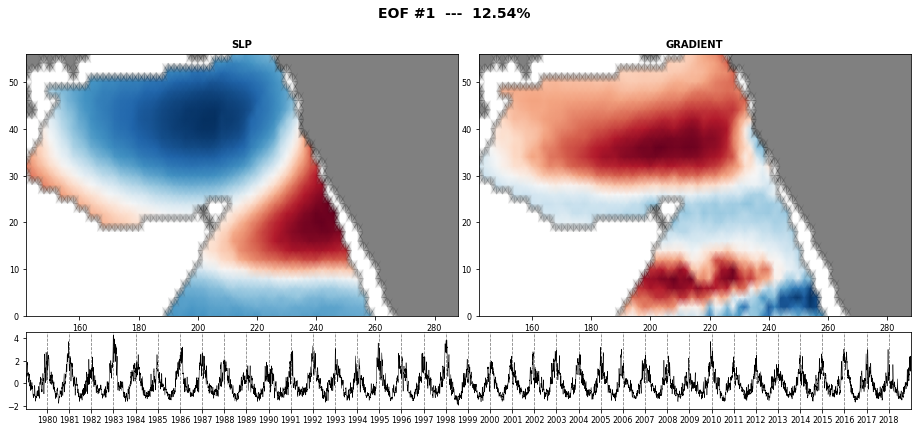

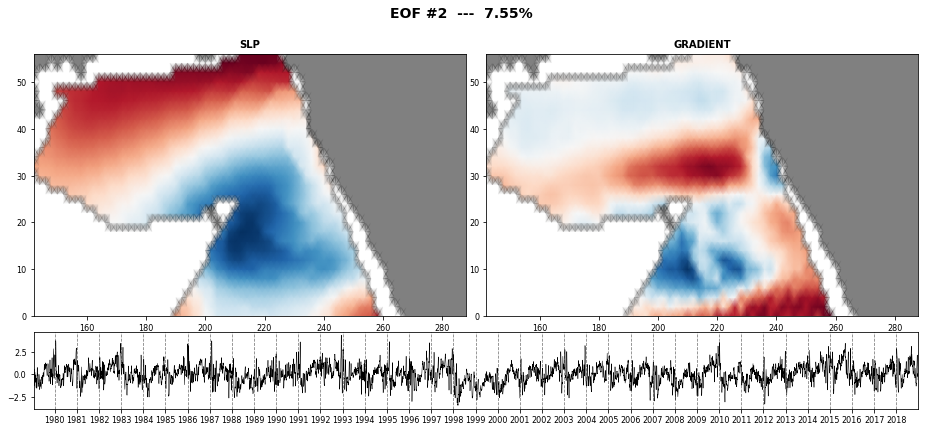

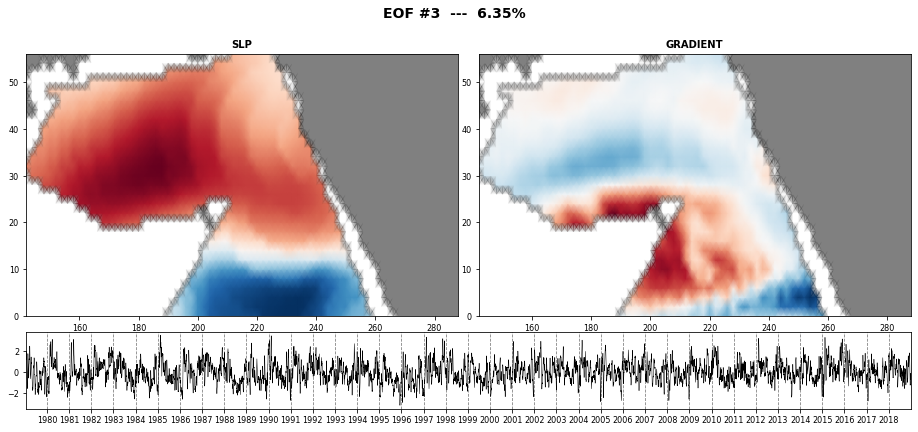

In [10]:
# plot PCA EOFs
n_EOFs = 3

pred.Plot_EOFs_EstelaPred(n_EOFs, show=True);



## ESTELA Predictor - KMeans Classification

In [11]:
# Calculate KMA (regression guided with WAVES data)
pred.Calc_KMA_regressionguided(
    num_clusters,
    WAVES_d, ['Hs','Tp','Fe'],
    kmarg_alpha, min_group_size=60,
)


  c: 26 - s: 43
  c: 28 - s: 36
  c: 34 - s: 13
  c: 35 - s: 9
total attemps:  1

  c: 17 - s: 6
  c: 19 - s: 51
  c: 23 - s: 22
  c: 29 - s: 14
  c: 35 - s: 44
total attemps:  2

  c: 9 - s: 24
  c: 10 - s: 11
  c: 13 - s: 40
  c: 25 - s: 10
  c: 26 - s: 14
  c: 32 - s: 9
  c: 34 - s: 12
total attemps:  3

  c: 5 - s: 51
  c: 17 - s: 14
  c: 18 - s: 25
  c: 20 - s: 13
  c: 28 - s: 31
  c: 34 - s: 8
total attemps:  4

  c: 1 - s: 42
  c: 12 - s: 20
total attemps:  5

  c: 9 - s: 49
  c: 30 - s: 19
  c: 35 - s: 34
total attemps:  6

  c: 6 - s: 40
  c: 25 - s: 6
  c: 28 - s: 6
  c: 34 - s: 35
total attemps:  7

  c: 8 - s: 3
  c: 21 - s: 58
  c: 31 - s: 31
total attemps:  8

  c: 4 - s: 11
  c: 7 - s: 23
  c: 18 - s: 14
  c: 23 - s: 35
  c: 26 - s: 15
  c: 30 - s: 5
  c: 34 - s: 20
  c: 35 - s: 32
total attemps:  9

  c: 8 - s: 5
  c: 9 - s: 4
  c: 25 - s: 35
  c: 33 - s: 54
  c: 35 - s: 26
total attemps:  10

  c: 4 - s: 58
  c: 6 - s: 14
  c: 10 - s: 46
  c: 13 - s: 26
  c: 18 - s: 23

In [12]:

print(pred.KMA)


<xarray.Dataset>
Dimensions:           (n_clusters: 36, n_components: 14590, n_features: 97)
Dimensions without coordinates: n_clusters, n_components, n_features
Data variables:
    bmus              (n_components) int32 27 27 27 20 27 27 ... 22 22 25 25 26
    cenEOFs           (n_clusters, n_features) float64 0.7175 ... -0.2374
    centroids         (n_clusters, n_features) float64 15.81 -10.26 ... 3.263
    group_size        (n_clusters) int64 382 102 120 392 844 ... 265 285 861 134
    sorted_order      (n_clusters) int32 19 9 2 24 5 10 1 ... 30 34 13 25 26 8
    sorted_bmus       (n_components) int32 23 23 23 14 23 23 ... 10 10 33 33 34
    sorted_cenEOFs    (n_clusters, n_features) float64 0.06095 0.2052 ... 0.3252
    sorted_centroids  (n_clusters, n_features) float64 2.305 4.243 ... 4.341
    time              (n_components) datetime64[ns] 1979-01-21 ... 2018-12-31
Attributes:
    method:   regression guided
    alpha:    0.3


In [13]:
## if you've already run the KMA classification 

# Use our custom ESTELA Predictor 
pred = Predictor(db.paths.site.ESTELA.pred_slp)

# Load predictor PCA, KMA
pred.Load()

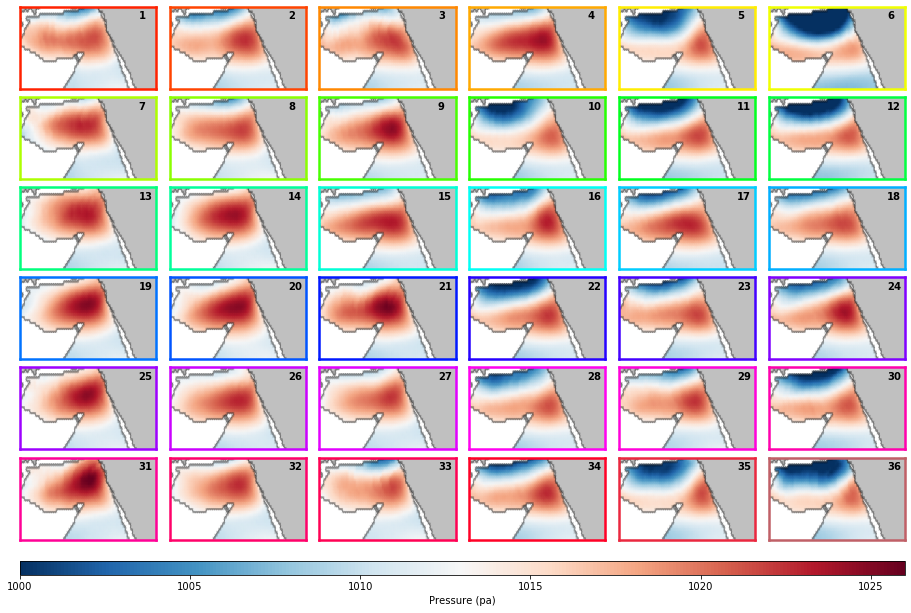

In [14]:
# Plot DWTs (data mean)
pred.Plot_DWTs('SLP', kind='mean', show=True);


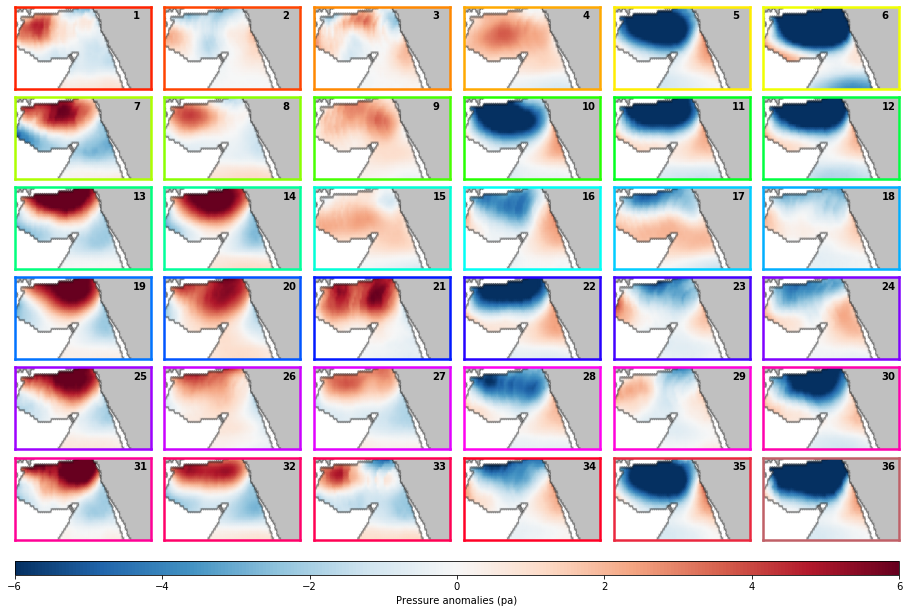

In [15]:
# Plot DWTs (data anomalies)
pred.Plot_DWTs('SLP', kind='anom', show=True);


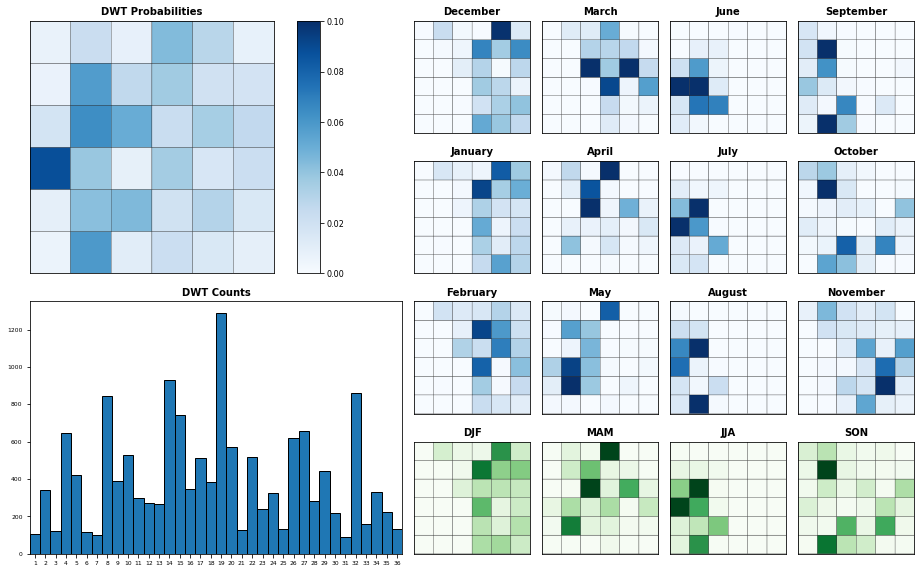

In [16]:
# Plot DWTs Probabilities
pred.Plot_DWTs_Probs();


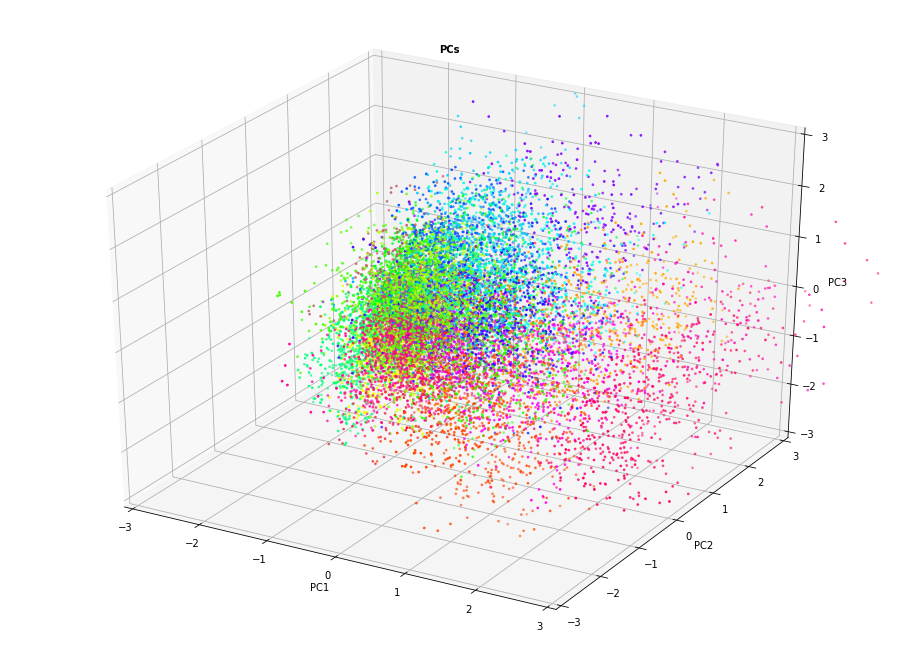

In [17]:
# Plot PC1, PC2, PC3 (3D)
pred.Plot_PCs_3D();


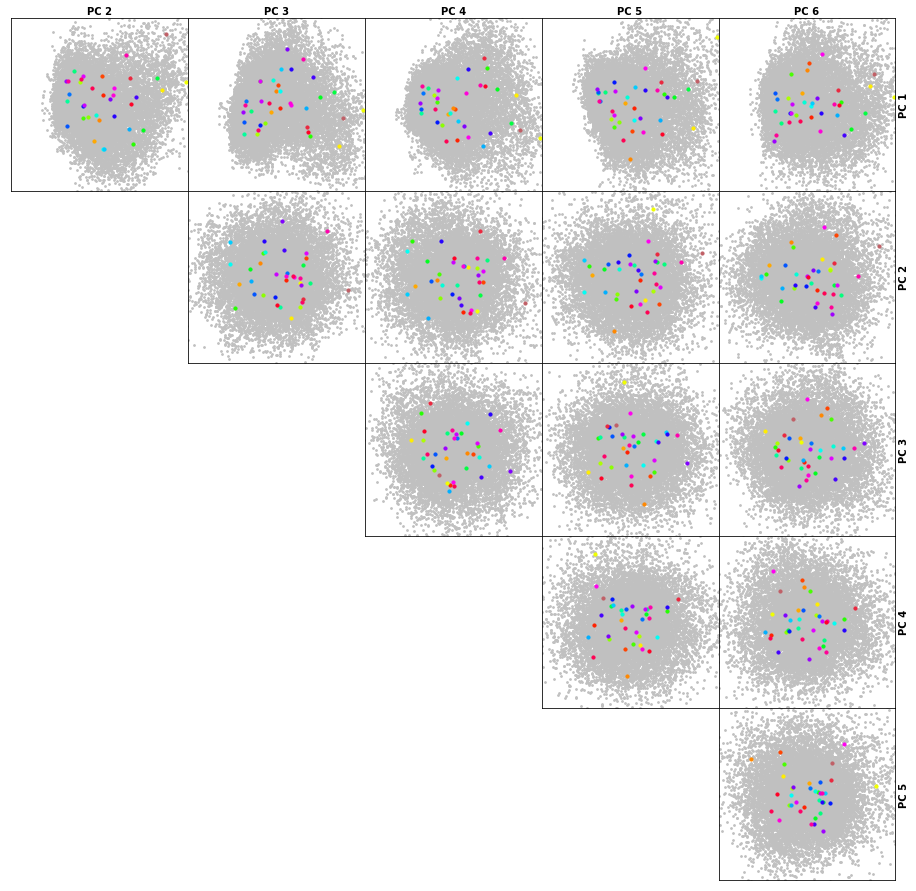

In [18]:
# Plot PCs DWT centroids
pred.Plot_DWT_PCs(n=6);



## ESTELA Predictor - Add Historical TCs

In [19]:
# --------------------------------------
# use historical storms-parameters inside r1 to modify predictor KMA results 

storm_dates = np.empty(0)
storm_categs = np.empty(0)

# add r1 storms to predictor KMA
pred.Mod_KMA_AddStorms(storm_dates, storm_categs)


In [20]:

print(pred.KMA)

<xarray.Dataset>
Dimensions:             (n_clusters: 36, n_components: 14590, n_features: 97)
Dimensions without coordinates: n_clusters, n_components, n_features
Data variables:
    bmus                (n_components) int32 ...
    cenEOFs             (n_clusters, n_features) float64 ...
    centroids           (n_clusters, n_features) float64 ...
    group_size          (n_clusters) int64 ...
    sorted_order        (n_clusters) int32 ...
    sorted_bmus         (n_components) int32 23 23 23 14 23 ... 10 10 33 33 34
    sorted_cenEOFs      (n_clusters, n_features) float64 ...
    sorted_centroids    (n_clusters, n_features) float64 ...
    time                (n_components) datetime64[ns] 1979-01-21 ... 2018-12-31
    sorted_bmus_storms  (n_components) int32 23 23 23 14 23 ... 10 10 33 33 34
Attributes:
    method:   regression guided
    alpha:    0.3


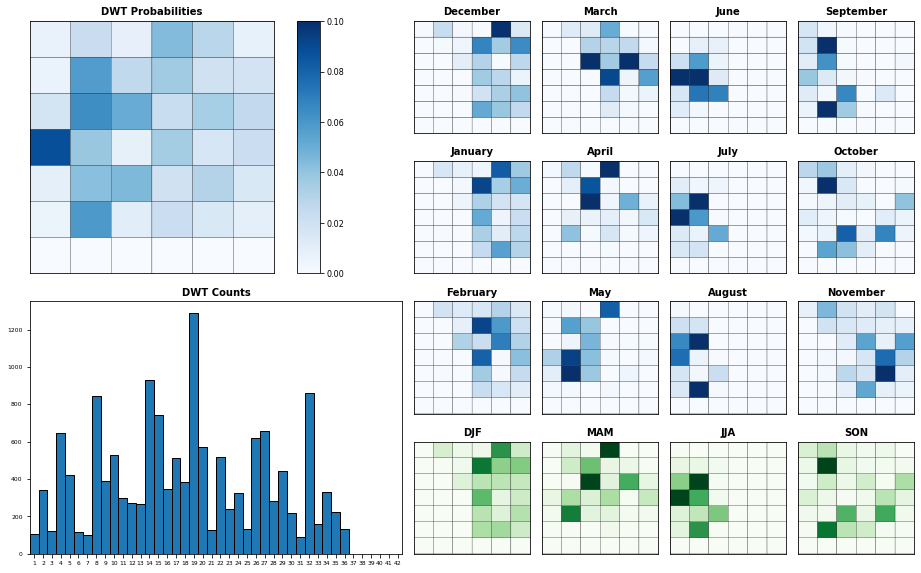

In [21]:
# Plot DWTs Probabilities with updated bmus
pred.Plot_DWTs_Probs(field='sorted_bmus_storms', n_clusters=42);


In [22]:
# --------------------------------------
# Calculate intradaily MU TAU hydrographs

l_MU_TAU = pred.Calc_MU_TAU_Hydrographs(WAVES)

# store hydrographs MU TAU
db.Save_MU_TAU_hydrograms(l_MU_TAU)


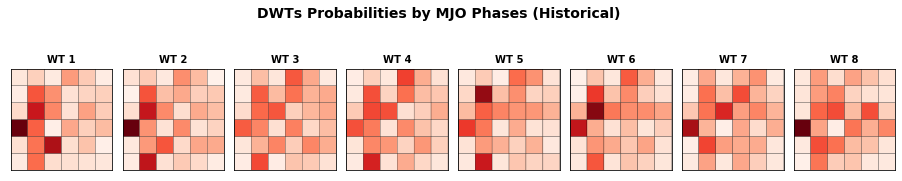

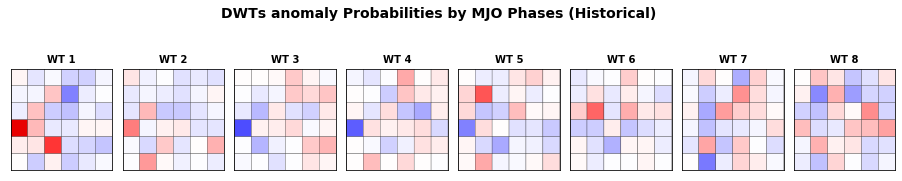

In [23]:
# Plot MJO phases / DWTs Probabilities 

# num. MJO phases and DWTs
MJO_ncs = 8
DWT_ncs = 36

# MJO, DWTs historical data
MJO_hist, DWT_hist = db.Load_MJO_DWTs_Plots_hist()

# categories to plot
MJO_phase = MJO_hist.phase.values[:]
DWT_bmus =  DWT_hist.bmus.values[:]

Plot_Probs_WT_WT(
    MJO_phase, DWT_bmus, MJO_ncs, DWT_ncs,
    wt_colors=False, ttl='DWTs Probabilities by MJO Phases (Historical)');


# plot DWTs conditional probabilities to each MJO, minus mean probabilities
Plot_Probs_WT_WT_anomaly(
    MJO_phase, DWT_bmus, MJO_ncs, DWT_ncs,
    wt_colors=False, ttl = 'DWTs anomaly Probabilities by MJO Phases (Historical)'
);


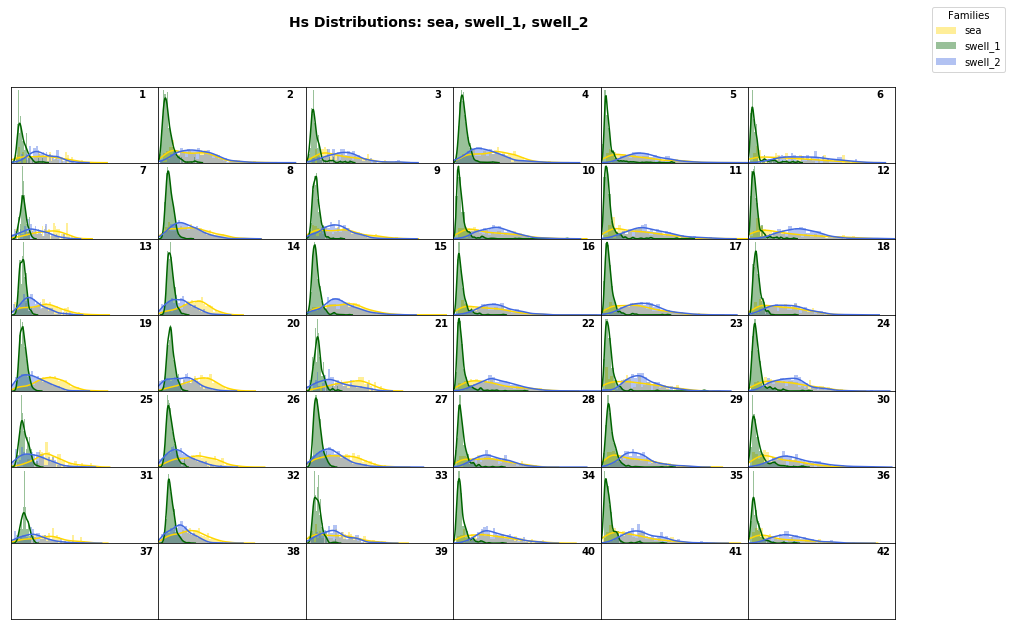

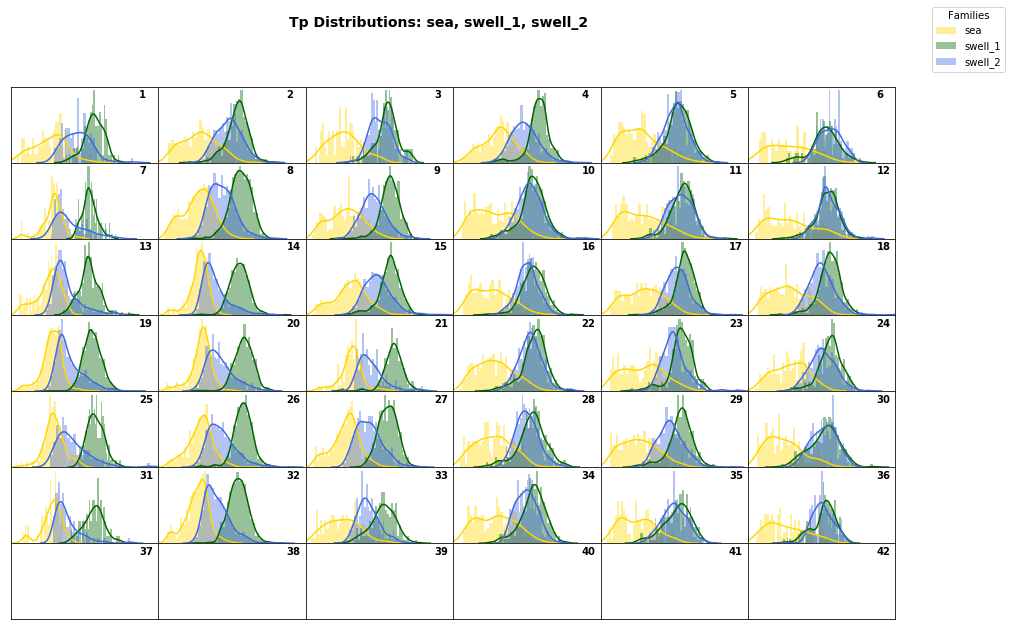

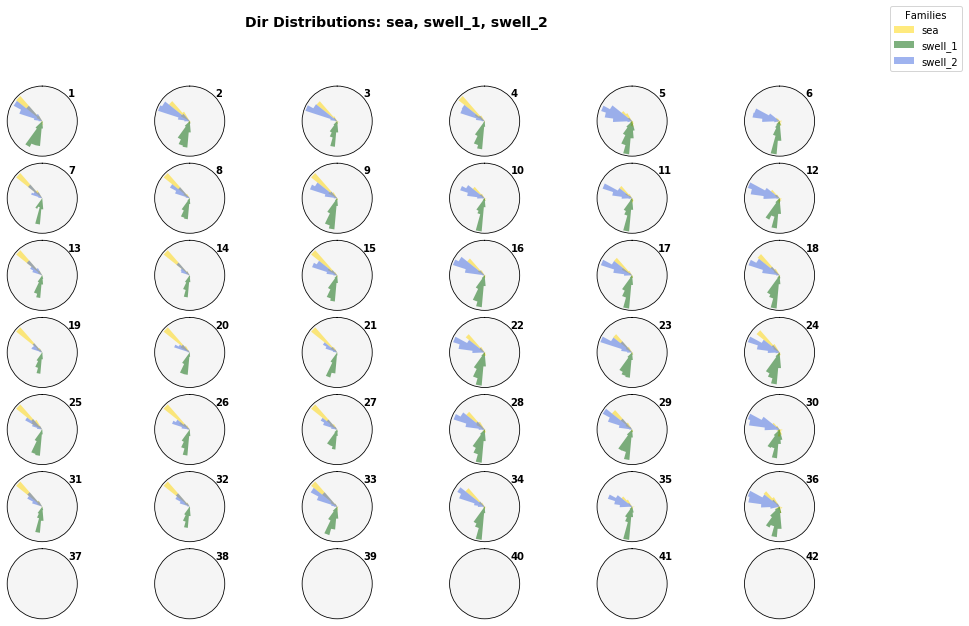

In [24]:
# Plot Waves Families by DWTs

# DWTs bmus
DWTs = pred.KMA
BMUS = xr.Dataset(
    {'bmus':(('time',), DWTs['sorted_bmus_storms'].values[:])},
    coords = {'time': DWTs.time.values[:]}
)
n_clusters = 42

# common dates
dates_common= xds_common_dates_daily([WAVES_d, DWTs])

# waves and bmus at common dates
WAVES_sel = WAVES_d.sel(time=dates_common)
bmus_sel = BMUS.sel(time=dates_common).bmus.values[:]

# Plot Waves Families by DWTs
Plot_Waves_DWTs(WAVES_sel, bmus_sel, n_clusters);


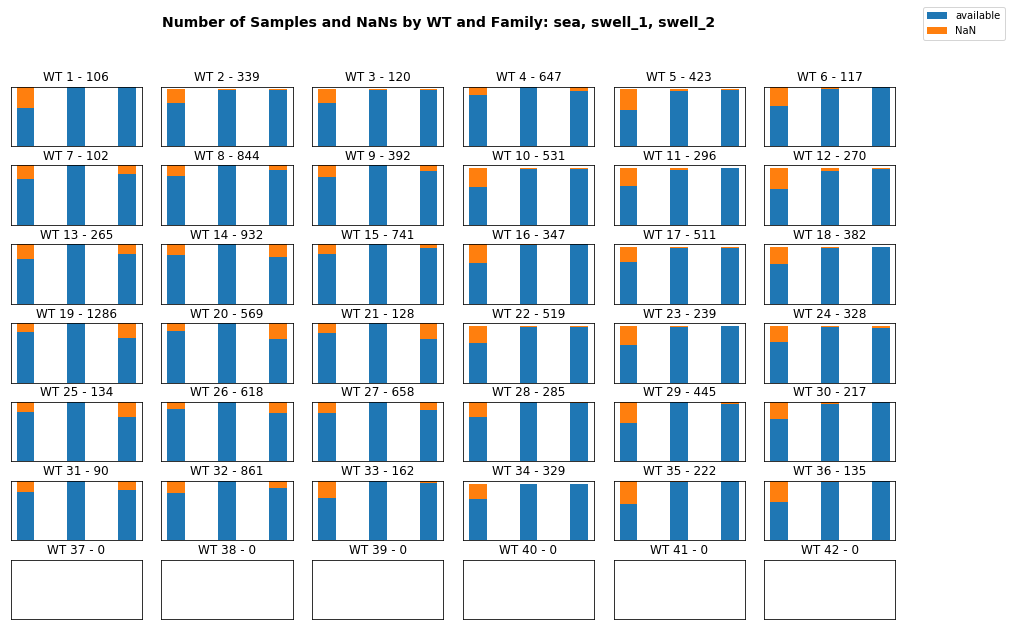

: 

In [25]:
# Plot DWT data population by families
Plot_DWTs_FamiliesPopulation(WAVES_sel, bmus_sel, n_clusters);


##  Code cell below will kill the running kernel so that the next notebook can operate correctly.

In [ ]:
import signal

# Get the current process ID (which is the kernel's process ID in this context)
pid = os.getpid()

# Send the SIGTERM signal to the current process
os.kill(pid, signal.SIGTERM)